In [195]:
'''pip install optax
pip install qiskit==0.45.2
pip install pennylane-qiskit
pip install qiskit-aer
pip install qiskit-ibm-runtime'''

'pip install optax\npip install qiskit==0.45.2\npip install pennylane-qiskit\npip install qiskit-aer\npip install qiskit-ibm-runtime'

In [3]:
from qiskit_ibm_runtime.fake_provider import FakeCairoV2
from qiskit_aer.noise import NoiseModel
import pennylane as qml

from openfermion.transforms import jordan_wigner
from openfermion.utils import load_operator
from pennylane import qchem
from pennylane import numpy as np
import matplotlib.pyplot as plt

Defining the Hamiltonian of the problem

In [4]:
n_site = 2
n_qubits = 2 * n_site
H_openfermion = load_operator(
    file_name=f"{n_qubits}_qubits_H",
    data_directory="./hamiltonian",
    plain_text=False,
)
H_openfermion_jw = jordan_wigner(H_openfermion)
H = qml.import_operator(H_openfermion_jw)


Defining the ideal device

In [5]:
dev_ideal = qml.device("default.qubit", wires=n_qubits)

Defining the noisy device 

In [6]:
noise_strength = 0.02
dev_noise_free = qml.device("default.mixed", wires=n_qubits, shots=1000)
dev_noisy = qml.transforms.insert(
    dev_noise_free,
    qml.AmplitudeDamping,
    noise_strength
)

Decomposition of single and double excitations in terms of Pauli gates

In [7]:
def full_double_excitation_decomposition(params, wires):
    # voir la ref
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.CNOT(wires=[wires[0], wires[2]])
    qml.Hadamard(wires=wires[0])
    qml.Hadamard(wires=wires[3])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.RY( - params / 8, wires=wires[0])
    qml.RY(params / 8, wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[3]])
    qml.Hadamard(wires=wires[3])
    qml.CNOT(wires=[wires[3], wires[1]])
    qml.RY( - params / 8, wires=wires[0])
    qml.RY(params / 8, wires=wires[1])
    qml.CNOT(wires=[wires[2], wires[1]])
    qml.CNOT(wires=[wires[2], wires[0]])
    qml.RY(params / 8, wires=wires[0])
    qml.RY(- params / 8, wires=wires[1])
    qml.CNOT(wires=[wires[3], wires[1]])
    qml.Hadamard(wires=wires[3])
    qml.CNOT(wires=[wires[0], wires[3]])
    qml.RY( params / 8, wires=wires[0])
    qml.RY(-params / 8, wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.CNOT(wires=[wires[2], wires[0]])
    qml.Hadamard(wires=wires[0])
    qml.Hadamard(wires=wires[3])
    qml.CNOT(wires=[wires[0], wires[2]])
    qml.CNOT(wires=[wires[2], wires[3]])
 
def full_single_excitation_decomposition(params, wires):
    # voir la ref
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params / 2, wires=wires[0])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(-params / 2, wires=wires[0])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.CNOT(wires=[wires[0], wires[1]]) 

Elimination of the excitations that has no contribution

Generation of all the possible excitations 

In [8]:
singles, doubles = qchem.excitations(n_site, n_qubits) #half filling
print(f"Single£ excitations = {singles}")
print(f"Double excitations = {doubles}")

Single£ excitations = [[0, 2], [1, 3]]
Double excitations = [[0, 1, 2, 3]]


In [9]:
hf = qml.qchem.hf_state(n_site, n_qubits)
def circuit_excitations_selection(params, singles, doubles):
    qml.BasisState(hf, wires=range(n_qubits))
    i=0
    for excitation in doubles:
            qml.DoubleExcitation(params[i], wires=excitation)
            i+=1
    for excitation in singles :
            qml.SingleExcitation(params[i], wires=excitation)
            i+=1
    return qml.expval(H)

Calculation of the gradient of each excitation

In [10]:
cost_fn = qml.QNode(circuit_excitations_selection, dev_ideal, interface="autograd")
circuit_gradient = qml.grad(cost_fn, argnum=0)
params = [0.0] * len(doubles+singles)
grads = circuit_gradient(params, singles, doubles)

for i in range(len(doubles)):
    print(f"Excitation : {doubles[i]}, Gradient: {grads[i]}")



Excitation : [0, 1, 2, 3], Gradient: -1.4999939439917536


In [11]:
doubles_select = [doubles[i] for i in range(len(doubles)) if abs(grads[i]) > 1.0e-6]
doubles_select

[[0, 1, 2, 3]]

In [12]:
cost_fn = qml.QNode(circuit_excitations_selection, dev_ideal, interface="autograd")

circuit_gradient = qml.grad(cost_fn, argnum=0)

params = [0.0] * len(singles+doubles)
grads = circuit_gradient(params, singles, doubles)

for i in range(len(singles)):
    print(f"Excitation : {singles[i]}, Gradient: {grads[i]}")

Excitation : [0, 2], Gradient: -1.4999939439917536
Excitation : [1, 3], Gradient: 0.0


Selecting the excitations with a gradient superior to 1.0e-6

In [13]:
singles_select = [singles[i] for i in range(len(singles)) if abs(grads[i]) > 1.0e-5]
singles_select

[[0, 2]]

Defining the new ansatz with the useful excitations

In [14]:
def circuit(params):
    qml.BasisState(hf, wires=range(n_qubits))
    i=0
    for d in  doubles_select:
        full_double_excitation_decomposition(params[i], wires= d)
        #qml.DoubleExcitation(params[i], wires=d)
        i+=1
    for s in singles_select:
        #qml.SingleExcitation(params[i], wires=s)
        full_single_excitation_decomposition(params[i], wires = s)
        i+=1
    return qml.expval(H)

In [15]:

max_iterations = 100
conv_tol = 1e-10
opt = qml.GradientDescentOptimizer(stepsize=0.5)


## Running the VQE in the ideal device

In [16]:
import time
opt = qml.GradientDescentOptimizer(stepsize=0.5)

''''def cost_fn(params):
    @qml.qnode(dev_noise_free)
    def circuit(params, gates_select):
        return circuit_2(params, gates_select)
    return circuit(params,gates_select)'''
qnode = qml.QNode(circuit, dev_ideal)
params = np.zeros(len(doubles_select + singles_select), requires_grad=True)

gates_select = doubles_select + singles_select
energies = [0]
for n in range(500):
    params, energy = opt.step_and_cost(qnode, params)
    energies.append(energy)
    conv = np.abs(energies[-1] - energies[-2])
    print("n = {:},  E = {:.8f} H".format(n, energy))

    if conv <= conv_tol:
        break

n = 0,  E = -3.50000000 H
n = 1,  E = -3.98583255 H
n = 2,  E = -3.99912702 H
n = 3,  E = -3.99994209 H
n = 4,  E = -3.99999297 H
n = 5,  E = -3.99999615 H
n = 6,  E = -3.99999635 H
n = 7,  E = -3.99999637 H
n = 8,  E = -3.99999637 H
n = 9,  E = -3.99999637 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/pennylane/ops/functions/eigvals.py:116: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


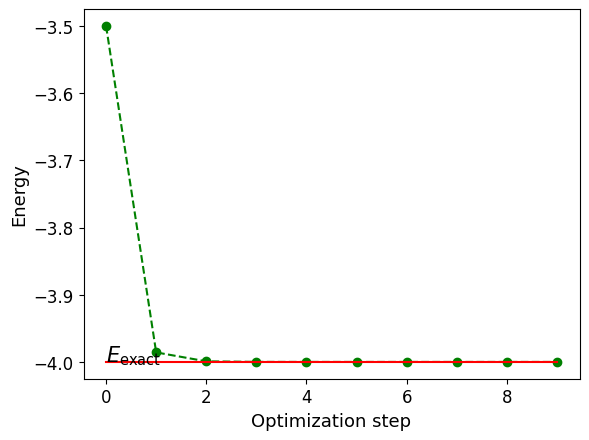

In [17]:
import matplotlib.pyplot as plt
energies.pop(0)
E = np.min(qml.eigvals(H))
plt.plot(range(len(energies)),energies,"go",ls="dashed")
plt.plot(range(len(energies)), np.full(len(energies), E), color="red")
plt.text(0, E, r"$E_\mathrm{exact}$", fontsize=15)
plt.xlabel("Optimization step", fontsize=13)
plt.ylabel("Energy", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Running VQE in a noisy device

In [29]:
import time
opt = qml.GradientDescentOptimizer(stepsize=0.5)
scale_factors = [1.0, 2.0, 3.0]

qnode_noisy = qml.QNode(circuit, dev_noisy)

params = np.zeros(len(doubles_select + singles_select), requires_grad=True)

gates_select = doubles_select + singles_select
energies_noisy = [0]
conv_tol = 1.0e-6
for n in range(300):
    params, energy = opt.step_and_cost(qnode_noisy, params)
    energies_noisy.append(energy)
    conv = np.abs(energies[-1] - energies[-2])
    print("n = {:},  E = {:.8f} H".format(n, energy))

n = 0,  E = -2.59400637 H
n = 1,  E = -2.84046525 H
n = 2,  E = -2.83510686 H
n = 3,  E = -2.79020787 H
n = 4,  E = -2.88649602 H
n = 5,  E = -2.87938282 H
n = 6,  E = -2.83236218 H
n = 7,  E = -2.81762307 H
n = 8,  E = -2.83559405 H
n = 9,  E = -2.84983129 H
n = 10,  E = -2.84542335 H
n = 11,  E = -2.88453674 H
n = 12,  E = -2.79831459 H
n = 13,  E = -2.84877036 H
n = 14,  E = -2.87708686 H
n = 15,  E = -2.83354243 H
n = 16,  E = -2.87096043 H
n = 17,  E = -2.88499680 H
n = 18,  E = -2.93696165 H
n = 19,  E = -2.86241376 H
n = 20,  E = -2.84984473 H
n = 21,  E = -2.83505682 H
n = 22,  E = -2.79307026 H
n = 23,  E = -2.81922848 H
n = 24,  E = -2.82223418 H
n = 25,  E = -2.82683771 H
n = 26,  E = -2.82169639 H
n = 27,  E = -2.84516583 H
n = 28,  E = -2.80510581 H
n = 29,  E = -2.87831655 H
n = 30,  E = -2.84153752 H
n = 31,  E = -2.84057240 H
n = 32,  E = -2.80474180 H
n = 33,  E = -2.90233704 H
n = 34,  E = -2.85867400 H
n = 35,  E = -2.86371054 H
n = 36,  E = -2.86662855 H
n = 37,  E 

In [18]:
print(energies_noisy)

NameError: name 'energies_noisy' is not defined

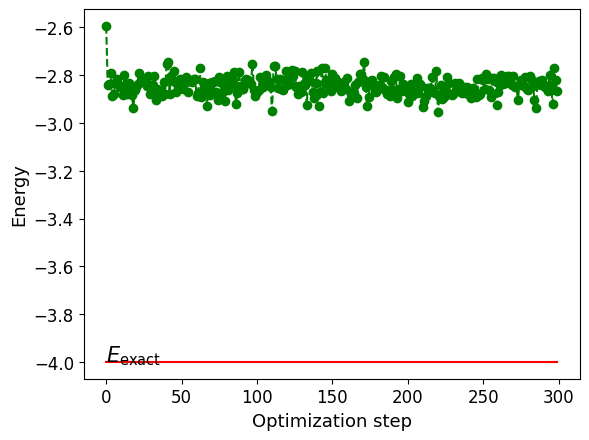

In [32]:
import matplotlib.pyplot as plt
energies_noisy.pop(0)
E = np.min(qml.eigvals(H))
plt.plot(range(len(energies_noisy)),energies_noisy,"go",ls="dashed")
plt.plot(range(len(energies_noisy)), np.full(len(energies_noisy), E), color="red")
plt.text(0, E, r"$E_\mathrm{exact}$", fontsize=15)
plt.xlabel("Optimization step", fontsize=13)
plt.ylabel("Energy", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Running VQE with error mitigation ZNE in a noisy device

Defining the ZNE parameters (scale factor, method of extrapolation...)

Defining the ansatz :

In [19]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from mitiq.zne import mitigate_executor
from mitiq.zne.inference import RichardsonFactory

from mitiq.zne.scaling import fold_global 
import pennylane_qiskit
from pennylane.transforms import mitigate_with_zne

In [20]:
@qml.qnode(dev_noisy)
def circuit_noisy(params):
    qml.BasisState(hf, wires=range(n_qubits))
    i=0
    for d in  doubles_select:
        full_double_excitation_decomposition(params[i], wires= d)
        #qml.DoubleExcitation(params[i], wires=d)
        i+=1
    for s in singles_select:
        #qml.SingleExcitation(params[i], wires=s)
        full_single_excitation_decomposition(params[i], wires = s)
        i+=1
    return qml.expval(H)

In [21]:
pip install numba

/Applications/Anaconda/anaconda3/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [41]:
import time
import pennylane as qml
from mitiq.zne.scaling import fold_gates_from_left
from mitiq.zne.inference import ExpFactory, RichardsonFactory, PolyFactory


opt = qml.GradientDescentOptimizer(stepsize=0.5)


qnode_noisy = qml.QNode(circuit_noisy, dev_noisy)
scale_factors = [1, 2, 5]
#order = 2
extrapolate = RichardsonFactory.extrapolate
#extrapolate = PolyFactory.extrapolate
#factory = zne.inference.PolyFactory(scale_factors=[1, 1.5, 2, 2.5, 3], order=2)
qnode_mitigated = qml.transforms.mitigate_with_zne(circuit_noisy,
    scale_factors,
    fold_gates_from_left,
    extrapolate,
    #PolyFactory.extrapolate,
    #extrapolate_kwargs = {"order" : 2}
)
params = np.zeros(len(doubles+ singles), requires_grad=True)

energies_mitigated = [0]
conv_tol = 1.0e-6
for n in range(300):
    
    params, energy = opt.step_and_cost(qnode_mitigated, params)
    energies_mitigated.append(energy)
    print("n = {:},  E = {:.8f} H".format(n, energy))

/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 0,  E = -3.64820635 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 1,  E = -3.50610498 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 2,  E = -3.87690180 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 3,  E = -3.85187255 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 4,  E = -3.30503812 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 5,  E = -3.95762018 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 6,  E = -3.32543325 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 7,  E = -3.46915512 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 8,  E = -3.63100385 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 9,  E = -3.90484636 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 10,  E = -3.71284001 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 11,  E = -3.42037504 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 12,  E = -3.27444546 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 13,  E = -3.36235883 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 14,  E = -3.67750859 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 15,  E = -3.61131922 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 16,  E = -3.63146420 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 17,  E = -3.56369704 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 18,  E = -3.31815511 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 19,  E = -3.61571064 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 20,  E = -3.41681084 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 21,  E = -3.84481893 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 22,  E = -3.49233011 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 23,  E = -3.53482588 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 24,  E = -3.76124238 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 25,  E = -3.44219584 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 26,  E = -3.55677976 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 27,  E = -3.69438417 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 28,  E = -3.88828498 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 29,  E = -3.53407245 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 30,  E = -3.40784457 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 31,  E = -3.91644344 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 32,  E = -3.43504103 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 33,  E = -3.27844283 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 34,  E = -3.44072469 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 35,  E = -3.62915003 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 36,  E = -3.80818476 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 37,  E = -3.49970393 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 38,  E = -3.25987283 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 39,  E = -3.37102053 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 40,  E = -3.00426627 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 41,  E = -3.81727252 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 42,  E = -3.76019432 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 43,  E = -3.44704574 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 44,  E = -3.61107198 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 45,  E = -3.39547753 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 46,  E = -3.24869641 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 47,  E = -3.43708846 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 48,  E = -3.61004570 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 49,  E = -3.48299948 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 50,  E = -3.92481078 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 51,  E = -3.40520247 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 52,  E = -3.83252013 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 53,  E = -3.54055931 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 54,  E = -3.39716997 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 55,  E = -3.66251944 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 56,  E = -3.76099994 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 57,  E = -3.55751488 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 58,  E = -3.40765447 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 59,  E = -3.58647682 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 60,  E = -3.37858862 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 61,  E = -3.64072052 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 62,  E = -3.28704925 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 63,  E = -3.73980902 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 64,  E = -3.32307379 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 65,  E = -3.65998065 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 66,  E = -3.64150438 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 67,  E = -3.99730340 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 68,  E = -3.38894900 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 69,  E = -3.48470705 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 70,  E = -3.80733829 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 71,  E = -3.61209013 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 72,  E = -3.58842263 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 73,  E = -3.46707757 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 74,  E = -3.49420972 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 75,  E = -3.44751764 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 76,  E = -3.81631472 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 77,  E = -3.35491702 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 78,  E = -3.28205108 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 79,  E = -3.45181113 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 80,  E = -3.89942551 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 81,  E = -3.59919162 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 82,  E = -3.43547255 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 83,  E = -3.60918331 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 84,  E = -3.42920317 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 85,  E = -3.52720276 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 86,  E = -3.75229540 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 87,  E = -3.41400807 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 88,  E = -3.82359882 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 89,  E = -3.48065736 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 90,  E = -3.62924837 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 91,  E = -3.38421420 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 92,  E = -3.39728199 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 93,  E = -3.45266002 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 94,  E = -3.93690474 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 95,  E = -3.37617739 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 96,  E = -4.01015606 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 97,  E = -3.60132887 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 98,  E = -3.66880104 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 99,  E = -3.39063973 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 100,  E = -3.71120135 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 101,  E = -3.80537662 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 102,  E = -3.78254890 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 103,  E = -3.91499664 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 104,  E = -3.26646442 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 105,  E = -3.23901754 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 106,  E = -3.68367982 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 107,  E = -3.62028884 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 108,  E = -3.74082794 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 109,  E = -3.38579119 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 110,  E = -3.53114131 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 111,  E = -3.66824666 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 112,  E = -3.69636492 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 113,  E = -3.47686853 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 114,  E = -3.66060484 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 115,  E = -3.46277437 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 116,  E = -3.66550054 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 117,  E = -3.58499379 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 118,  E = -3.48152530 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 119,  E = -3.59266928 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 120,  E = -3.60575757 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 121,  E = -3.55575885 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 122,  E = -3.66081591 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 123,  E = -3.50193488 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 124,  E = -3.78799270 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 125,  E = -3.56827841 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 126,  E = -3.72331685 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 127,  E = -3.69205156 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 128,  E = -3.66015903 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 129,  E = -3.52734861 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 130,  E = -3.67462146 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 131,  E = -3.26097160 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 132,  E = -3.71245755 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 133,  E = -3.58777544 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 134,  E = -3.60165913 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 135,  E = -3.39611028 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 136,  E = -3.85963142 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 137,  E = -3.49902197 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 138,  E = -3.51419979 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 139,  E = -3.45448988 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 140,  E = -3.67162053 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 141,  E = -3.68574699 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 142,  E = -3.65585169 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 143,  E = -3.40571082 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 144,  E = -3.30254538 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 145,  E = -3.47505548 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 146,  E = -3.39204729 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 147,  E = -3.35831108 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 148,  E = -3.37008811 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 149,  E = -3.54891592 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 150,  E = -3.33825063 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 151,  E = -3.45776880 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 152,  E = -3.82068960 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 153,  E = -3.38411739 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 154,  E = -3.27900712 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 155,  E = -3.43823373 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 156,  E = -3.50196678 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 157,  E = -3.56647109 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 158,  E = -3.88565358 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 159,  E = -3.50406495 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 160,  E = -3.83800104 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 161,  E = -3.77872888 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 162,  E = -3.50300744 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 163,  E = -3.75995212 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 164,  E = -3.25122472 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 165,  E = -3.46376336 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 166,  E = -3.56049630 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 167,  E = -3.61573817 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 168,  E = -3.72425257 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 169,  E = -3.42763179 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 170,  E = -3.79154091 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 171,  E = -3.42902176 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 172,  E = -3.46495957 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 173,  E = -3.59608358 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 174,  E = -4.04600985 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 175,  E = -3.61096346 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 176,  E = -3.45782117 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 177,  E = -3.76227194 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 178,  E = -3.41302969 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 179,  E = -3.23020862 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 180,  E = -3.19059777 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 181,  E = -3.51501465 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 182,  E = -3.73152467 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 183,  E = -3.59872832 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 184,  E = -3.32302696 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 185,  E = -3.59535602 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 186,  E = -3.72033950 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 187,  E = -3.28601527 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 188,  E = -3.62165795 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 189,  E = -3.60870991 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 190,  E = -3.69799719 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 191,  E = -3.55476717 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 192,  E = -3.17893440 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 193,  E = -3.68763025 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 194,  E = -3.53456274 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 195,  E = -3.58896318 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 196,  E = -3.47493396 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 197,  E = -3.88651922 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 198,  E = -3.51695826 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 199,  E = -3.46463762 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 200,  E = -3.69296592 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 201,  E = -3.48763136 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 202,  E = -3.35560576 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 203,  E = -3.45060929 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 204,  E = -3.68212615 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 205,  E = -3.43677200 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 206,  E = -3.56037211 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 207,  E = -3.60077009 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 208,  E = -3.70610743 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 209,  E = -3.70431031 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 210,  E = -3.41282038 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 211,  E = -3.75551948 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 212,  E = -3.33922797 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 213,  E = -3.68067517 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 214,  E = -3.73622742 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 215,  E = -3.54860929 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 216,  E = -3.64332369 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 217,  E = -3.65808676 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 218,  E = -3.33821134 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 219,  E = -3.47136585 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 220,  E = -3.74999309 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 221,  E = -3.38990330 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 222,  E = -3.57526429 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 223,  E = -3.70496669 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 224,  E = -3.29485395 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 225,  E = -3.76118861 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 226,  E = -3.60365246 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 227,  E = -3.68029730 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 228,  E = -3.32981557 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 229,  E = -3.64801258 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 230,  E = -3.38232582 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 231,  E = -3.29548259 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 232,  E = -3.85431926 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 233,  E = -3.68316431 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 234,  E = -3.64448062 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 235,  E = -3.30545543 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 236,  E = -3.65679760 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 237,  E = -3.42425693 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 238,  E = -3.48035148 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 239,  E = -3.20926730 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 240,  E = -3.76941545 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 241,  E = -3.74207198 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 242,  E = -3.30822074 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 243,  E = -3.36967503 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 244,  E = -3.46895257 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 245,  E = -3.62534229 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 246,  E = -3.67904126 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 247,  E = -3.75166252 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 248,  E = -3.33369940 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 249,  E = -3.81768198 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 250,  E = -3.59823838 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 251,  E = -3.48023597 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 252,  E = -3.84447578 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 253,  E = -3.40162860 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 254,  E = -3.60606621 H


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


n = 255,  E = -3.82033686 H


KeyboardInterrupt: 

/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/pennylane/ops/functions/eigvals.py:116: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


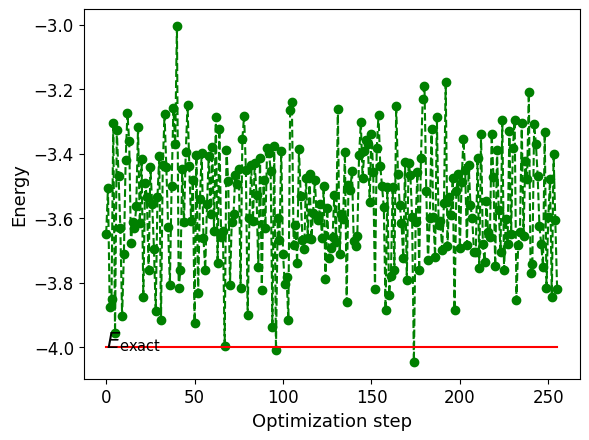

In [42]:
import matplotlib.pyplot as plt
energies_mitigated.pop(0)
E = np.min(qml.eigvals(H))
plt.plot(range(len(energies_mitigated)),energies_mitigated,"go",ls="dashed")
plt.plot(range(len(energies_mitigated)), np.full(len(energies_mitigated), E), color="red")
plt.text(0, E, r"$E_\mathrm{exact}$", fontsize=15)
plt.xlabel("Optimization step", fontsize=13)
plt.ylabel("Energy", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## MITIQ

In [38]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from mitiq.zne import mitigate_executor
from mitiq.zne.inference import ExpFactory
from mitiq.zne.scaling import fold_global as folding

In [40]:
extrapolate = ExpFactory.extrapolate
scale_factors = [1, 2, 3]
@qml.transforms.mitigate_with_zne(scale_factors, folding, extrapolate)
@qml.qnode(dev_noisy)#using noisy simulator with mitigation
def circuit_mitigated(params):
    qml.BasisState(hf, wires=range(n_qubits))
    i=0
    for d in  doubles_select:
        full_double_excitation_decomposition(params[i], wires= d)
        #qml.DoubleExcitation(params[i], wires=d)
        i+=1
    for s in singles_select:
        #qml.SingleExcitation(params[i], wires=s)
        full_single_excitation_decomposition(params[i], wires = s)
        i+=1
    return qml.expval(H)

/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/pennylane/transforms/core/transform_dispatcher.py:130: PennyLaneDeprecationWarning: Decorating a QNode with @transform_fn(**transform_kwargs) has been deprecated and will be removed in a future version. Please decorate with @functools.partial(transform_fn, **transform_kwargs) instead, or call the transform directly using qnode = transform_fn(qnode, **transform_kwargs). Visit the deprecations page for more details: https://docs.pennylane.ai/en/stable/development/deprecations.html
  warnings.warn(


In [43]:
import time
opt = qml.GradientDescentOptimizer(stepsize=0.5)
scale_factors = [1.0, 2.0,  3.0]
 
qnode_mitigated = qml.QNode(circuit_mitigated, dev_noisy)
params = np.zeros(len(doubles_select + singles_select), requires_grad=True)
 
gates_select = doubles_select + singles_select
energies_mitigated_exp = [0]
conv_tol = 1.0e-10
for n in range(200):
    params, energy = opt.step_and_cost(qnode_mitigated, params)
    energies_mitigated_exp.append(energy)
    conv = np.abs(energies_mitigated_exp[-1] - energies_mitigated_exp[-2])
    print("n = {:},  E = {:.8f} H".format(n, energy))

n = 0,  E = -2.55744016 H
n = 1,  E = -2.81593272 H
n = 2,  E = -2.73708162 H
n = 3,  E = -2.87221885 H
n = 4,  E = -2.88420754 H
n = 5,  E = -2.81552420 H
n = 6,  E = -2.91084727 H
n = 7,  E = -2.82181871 H
n = 8,  E = -2.83163732 H
n = 9,  E = -2.90555213 H
n = 10,  E = -2.77536725 H
n = 11,  E = -2.88294504 H
n = 12,  E = -2.85659869 H
n = 13,  E = -2.89701277 H
n = 14,  E = -2.85759557 H
n = 15,  E = -2.80405584 H
n = 16,  E = -2.82556729 H
n = 17,  E = -2.82474858 H
n = 18,  E = -2.79011376 H
n = 19,  E = -2.89513883 H
n = 20,  E = -2.83736095 H
n = 21,  E = -2.82146594 H
n = 22,  E = -2.86240994 H
n = 23,  E = -2.84427037 H
n = 24,  E = -2.87065610 H
n = 25,  E = -2.83502451 H
n = 26,  E = -2.89598811 H
n = 27,  E = -2.90745271 H
n = 28,  E = -2.77177064 H
n = 29,  E = -2.79432300 H
n = 30,  E = -2.90270774 H
n = 31,  E = -2.84756058 H
n = 32,  E = -2.83560402 H
n = 33,  E = -2.84970472 H
n = 34,  E = -2.77524128 H
n = 35,  E = -2.85099029 H
n = 36,  E = -2.77941969 H
n = 37,  E 

/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/pennylane/ops/functions/eigvals.py:116: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


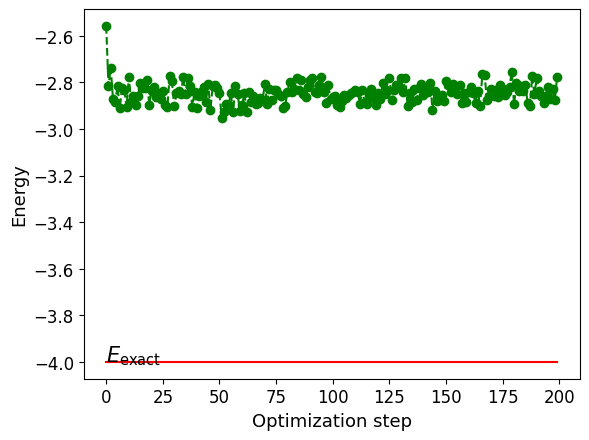

In [44]:
import matplotlib.pyplot as plt
energies_mitigated_exp.pop(0)
E = np.min(qml.eigvals(H))
plt.plot(range(len(energies_mitigated_exp)),energies_mitigated_exp,"go",ls="dashed")
plt.plot(range(len(energies_mitigated_exp)), np.full(len(energies_mitigated_exp), E), color="red")
plt.text(0, E, r"$E_\mathrm{exact}$", fontsize=15)
plt.xlabel("Optimization step", fontsize=13)
plt.ylabel("Energy", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## ZNE with local folding

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from mitiq.zne import mitigate_executor
from mitiq.zne.inference import RichardsonFactory
from mitiq.zne.scaling import fold_gates_from_left as folding
import pennylane_qiskit

In [ ]:
extrapolate = RichardsonFactory.extrapolate
scale_factors = [1, 2, 3]
@qml.transforms.mitigate_with_zne(scale_factors, folding, extrapolate)
@qml.qnode(dev_noisy)#using noisy simulator with mitigation
def circuit_local_folding(params) :
    qml.BasisState(hf, wires=range(n_qubits))
    for s in singles_select:
        qml.SingleExcitation(params, wires=s)
    for d in doubles_select:
        qml.DoubleExcitation(params, wires=d)
    return qml.expval(H)

/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/pennylane/transforms/core/transform_dispatcher.py:130: PennyLaneDeprecationWarning: Decorating a QNode with @transform_fn(**transform_kwargs) has been deprecated and will be removed in a future version. Please decorate with @functools.partial(transform_fn, **transform_kwargs) instead, or call the transform directly using qnode = transform_fn(qnode, **transform_kwargs). Visit the deprecations page for more details: https://docs.pennylane.ai/en/stable/development/deprecations.html
  warnings.warn(


## Evaluate noise-scaled expectation values



RichardsonFactory

In [ ]:
from mitiq import zne

# Choose a list of scale factors
scale_factors = [1.0, 2.0, 3.0]
# Generate a list of folded circuits
extrapolate = RichardsonFactory.extrapolate
scale_factors = [1, 2, 3]
@qml.qnode(dev_noisy)#using noisy simulator with mitigation
def circuit(params, wires=range(n_qubits)):
    qml.BasisState(hf, wires=range(n_qubits))
    for d in  doubles_select:
        full_double_excitation_decomposition(params, wires= d)
    for s in  singles_select:
        full_single_excitation_decomposition(params, wires = s)
    return qml.expval(H)

expectation_values = [qml.transforms.fold_global(circuit, s)(7) for s in scale_factors]
 
# Initialize a factory
fac = zne.inference.RichardsonFactory(scale_factors)

# Load data:
for s, e in zip(scale_factors, expectation_values):
    fac.push({"scale_factor": s}, e)

# Evaluate the extrapolation
fac.reduce()


/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


-3.4489560500481433

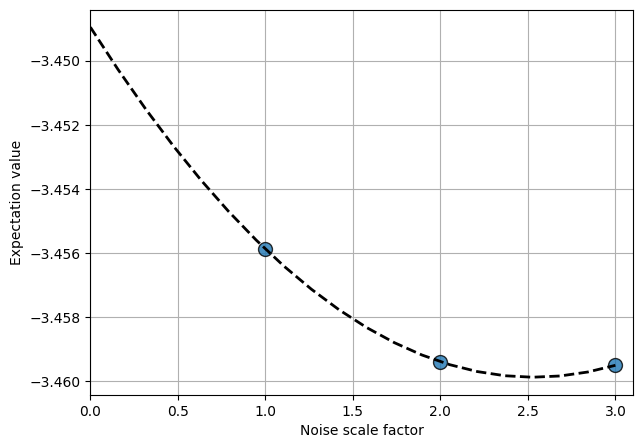

In [ ]:
_ = fac.plot_fit()

ExpFactory

In [ ]:
from mitiq import zne

# Choose a list of scale factors
scale_factors = [1, 2, 3]
@qml.qnode(dev_noisy)#using noisy simulator with mitigation
def circuit(params, wires=range(n_qubits)):
    qml.BasisState(hf, wires=range(n_qubits))
    for d in  doubles_select:
        full_double_excitation_decomposition(params, wires= d)
    for s in  singles_select:
        full_single_excitation_decomposition(params, wires = s)
    return qml.expval(H)

noise_scaled_circuits = [qml.transforms.fold_global(circuit, s) for s in scale_factors]
expectation_values = [qml.transforms.fold_global(circuit, s)(7) for s in scale_factors]
print(expectation_values)
# Initialize a factory
fac = zne.inference.ExpFactory(scale_factors, asymptote=0.5)
# Load data:
for s, e in zip(scale_factors, expectation_values):
    fac.push({"scale_factor": s}, e)

# Evaluate the extrapolation
fac.reduce()

/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/abdessamadoukermou/Downloads/Reply/.venv/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


[array(-3.46860882), array(-3.47540276), array(-3.46264258)]


-3.4748573710447803